
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os,sys
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask import compute, delayed
from dask.distributed import Client
# 
from datetime import datetime
#
from utils import *

/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/utils.py:121: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


satpy not available


/home1/datahome/aponte/.miniconda3/envs/pangeo/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
### get dask handles and check dask server status
client = Client(scheduler_file=os.path.expanduser('/home1/datawork/aponte/dask/scheduler.json'))
client.restart()
# upload utils.py to workers
client.upload_file('utils.py')

In [3]:
client

Client Scheduler: tcp://10.148.1.3:8786 Dashboard: http://10.148.1.3:8787,Cluster Workers: 62 Cores: 248 Memory: 620.00 GB


In [4]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; t1, t2, suff, vmin, vmax, slat, slon = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24), slice(108,126)

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
if 't1' in locals() and 't2' in locals():
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
print('Number of files processed: %d' %len(filenames))

Number of files available: 11417
Number of files processed: 1842


In [5]:
# open files
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

# spatial zoom
if 'slat' in locals():
    ds = ds.sel(lat=slat)

# sst in degC
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('SST dataset size: %.1f GB' %(ds['sea_surface_temperature'].nbytes/1e9))

CPU times: user 28.3 s, sys: 1.99 s, total: 30.3 s
Wall time: 1min 8s
SST dataset size: 8.9 GB


In [6]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 601, lon: 1001, time: 1842)
Coordinates:
  * lat                      (lat) float32 -12.0 -12.02 -12.04 -12.06 -12.08 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-09-03T00:10:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float64 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    wind_speed               (time, lat, lon) float64 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    solar_zenith_angle       (time, lat, lon) float64 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Agency(JA

---

# mean quantities

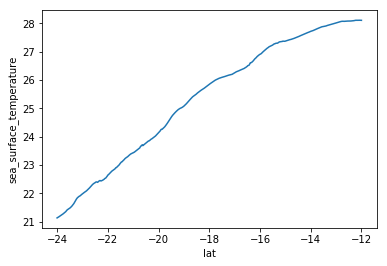

In [7]:
Tmean_xt = ds['sea_surface_temperature'].mean(['lon','time']).persist()
Tmean_xt.plot()

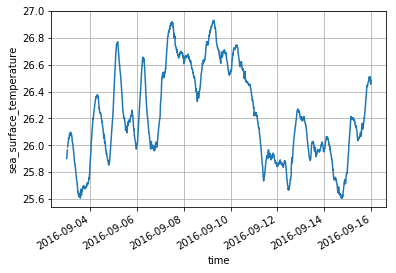

In [8]:
Tmean_xy = ds['sea_surface_temperature'].mean(dim=['lon','lat'])
Tmean_xy.plot()
plt.grid()

In [9]:
Tmean_t = ds['sea_surface_temperature'].mean('time').persist()

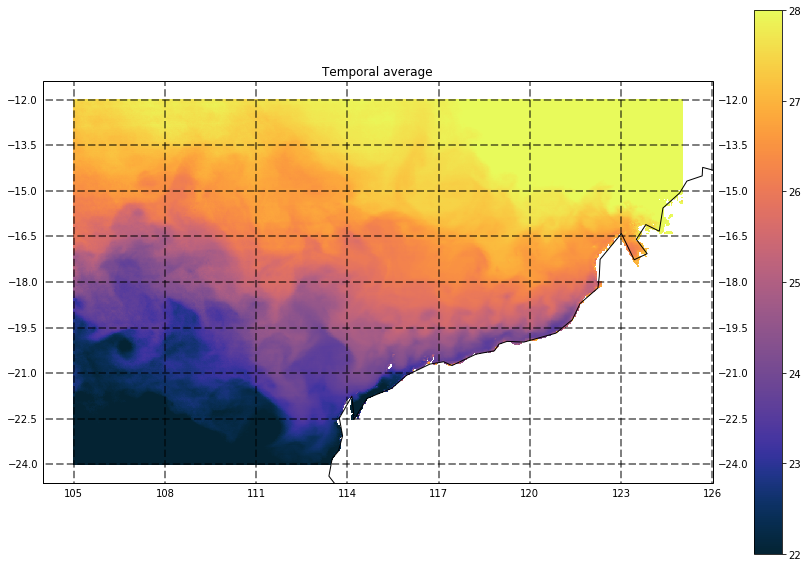

In [10]:
plot_sst(Tmean_t, title='Temporal average', vmin=22., vmax=28., figsize=(15,10))

---

# diurnal cycle

In [11]:
Tdcycle = (ds['sea_surface_temperature'].mean('lon') - Tmean_xt).groupby('time.hour').mean('time')
Tdcycle = Tdcycle.persist()

In [14]:
Tdcycle

<xarray.DataArray 'sea_surface_temperature' (hour: 24, lat: 601)>
dask.array<shape=(24, 601), dtype=float64, chunksize=(1, 601)>
Coordinates:
  * lat      (lat) float32 -12.0 -12.02 -12.04 -12.06 -12.08 -12.1 -12.12 ...
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

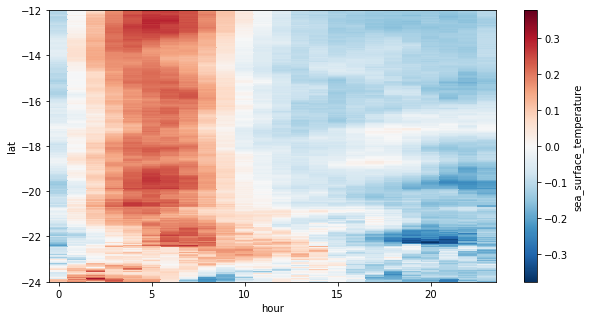

In [12]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
Tdcycle.T.plot(ax=ax)

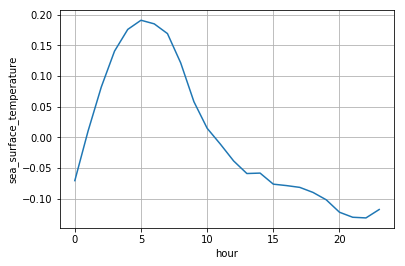

In [15]:
Tdcycle.mean('lat').plot()
plt.grid()

---

# zonally averaged temperature

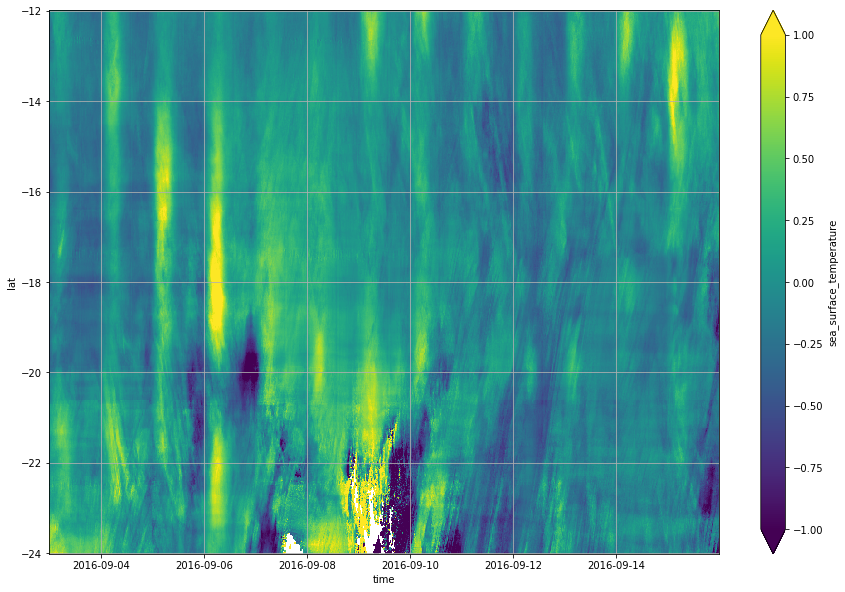

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
(ds['sea_surface_temperature'].mean('lon') - Tmean_xt).T.plot(ax=ax, vmin=-1., vmax=1.)
plt.grid()

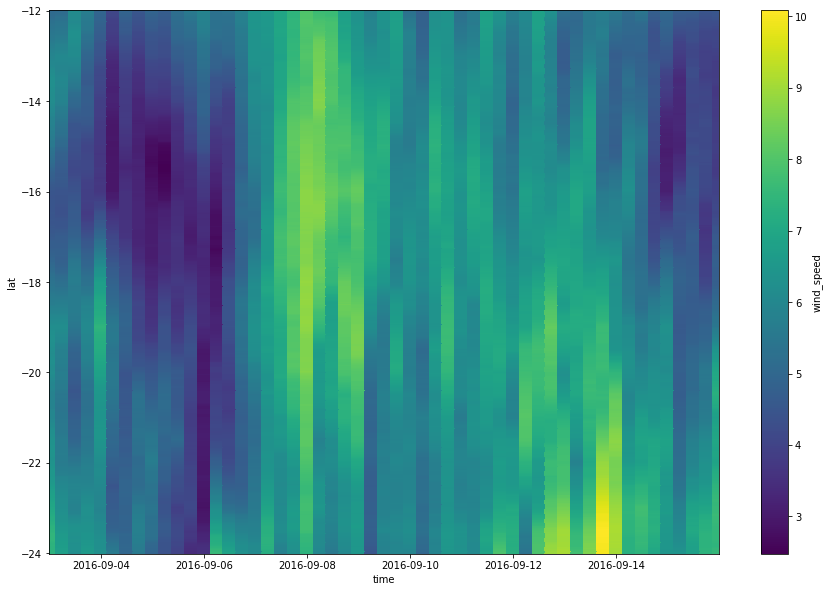

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
#ds['wind_speed'].mean('lon').T.plot(ax=ax, vmin=-1., vmax=1.)
ds['wind_speed'].mean('lon').T.plot(ax=ax)

---

# At single longitudes

In [26]:
T = ds['sea_surface_temperature'].sel(lon=116.,method='nearest')
T = T.sel(lat=slice(-15.,-21.5))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

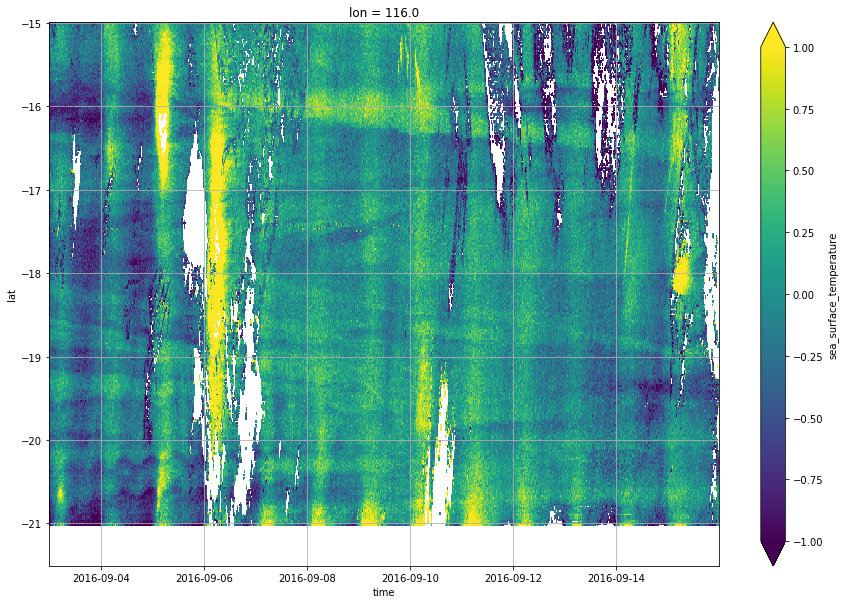

In [28]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()

In [19]:
T = ds['sea_surface_temperature'].sel(lon=120.,method='nearest')
T = T.sel(lat=slice(-12.,-20.))
#T = T.sel(time=slice('2016-09-04','2016-09-15'))
T += -T.mean('time')

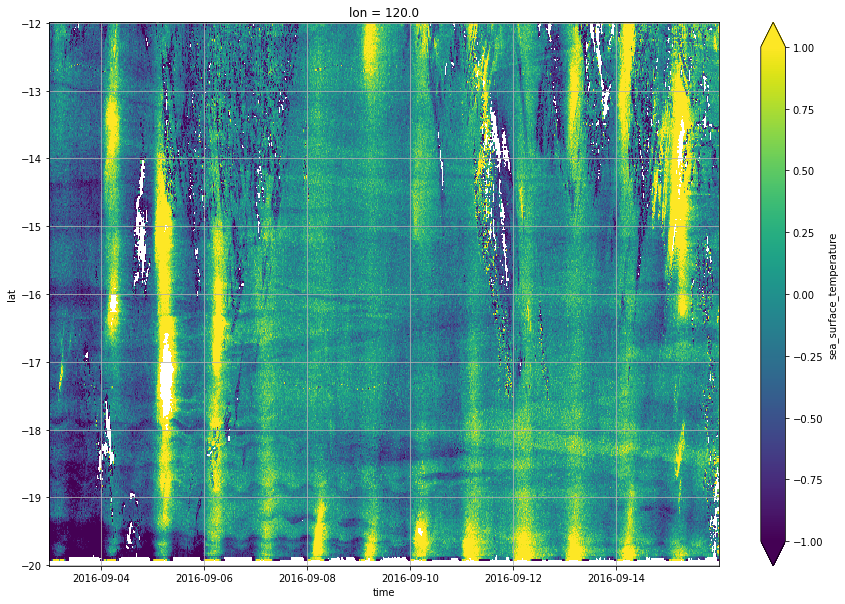

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
T.T.plot(ax=ax, vmin=-1., vmax=1.)
ax.grid()